TASK 1

I created a network of directors based on the companies they are connected to and used it to measure influence in three ways. First, I used degree centrality to see which directors are connected to the most others, showing who is most active across boards. Then I applied betweenness centrality to find directors who act as bridges between groups, meaning they could control or guide information flow. Finally, I added PageRank as a new centrality measure because it highlights directors who are not just well-connected but are linked to other important people too. This gives a better idea of their indirect power in the network. These three measures together give a clearer picture of who holds the most influence, visibility, and control among all directors.

In [7]:

import pandas as pd
import networkx as nx

# Load dataset
df = pd.read_csv('company_directorships.csv')  

# Build bipartite graph
B = nx.Graph()
B.add_nodes_from(df['company_name'], bipartite='companies')
B.add_nodes_from(df['director_name'], bipartite='directors')
B.add_edges_from(zip(df['director_name'], df['company_name']))

# Project to director-only graph
directors = {n for n, d in B.nodes(data=True) if d['bipartite'] == 'directors'}
G = nx.bipartite.weighted_projected_graph(B, directors)

# Degree Centrality
degree_centrality = nx.degree_centrality(G)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 Degree Centrality:")
for name, value in top_degree:
    print(f"{name}: {value:.4f}")

# Betweenness Centrality (on top 200 nodes)
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:200]
subgraph = G.subgraph([n for n, _ in top_nodes])
betweenness = nx.betweenness_centrality(subgraph)
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Betweenness Centrality:")
for name, value in top_betweenness:
    print(f"{name}: {value:.4f}")

# PageRank (new centrality measure)
pagerank = nx.pagerank(G)
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 PageRank:")
for name, value in top_pagerank:
    print(f"{name}: {value:.4f}")


Top 5 Degree Centrality:
MARK A. BLINN: 0.0098
ALBERT R. DOWDEN: 0.0074
MICHAEL F. JOHNSTON: 0.0072
MATTHEW J. ESPE: 0.0069
RONALD L. OLSON: 0.0068

Top 5 Betweenness Centrality:
MICHAEL F. JOHNSTON: 0.0799
MATTHEW J. ESPE: 0.0638
JOHN J. ROBERTS: 0.0596
MARK A. BLINN: 0.0591
EDWARD J. KELLY, III: 0.0536

Top 5 PageRank:
MARK A. BLINN: 0.0003
ROBERT T. BRADY: 0.0003
CHRISTOPHER L. MAPES: 0.0003
J. MICHAEL LOSH: 0.0003
MICHAEL F. HILTON: 0.0002


2. TASK 2
Code Repair (8 Marks)
In reviewing the code, I found several areas that made it hard to understand or could cause errors. I picked four key fixes that were most important for improving clarity, avoiding mistakes, and making future steps easier.

Fix 1: Inconsistent Column Name (name to NAME)
The original code used raw_directors['name'], but this column was later converted to uppercase. I renamed the column properly at the start ('name' to 'NAME') so it stays consistent throughout the code. This reduces confusion and avoids errors when grouping or merging later.

Fix 2: Software Background Cleanup
The original data had software_background as the letter 't' to mean true. I converted it to a proper boolean (True/False) so it can be used easily in filtering or modeling. This makes the data more usable and less error-prone.

Fix 3: Add ‘role’ to Demographics Summary
The summary DataFrame originally left out the role column, which is important when merging later with centrality or influence scores. I added the most common role per person to the summary so that information is kept and can be used in later steps.

Fix 4: Reset Index for Safe Merging
When grouping data, the resulting index becomes the grouped column (NAME). This can cause merge errors later if not handled properly. I reset the index of the final DataFrame so it's easier to merge with other outputs like centrality scores or graphs.

Each fix was chosen to improve either the clarity, correctness, or future usability of the code — especially for someone working on it later. Together, these changes make the workflow easier to follow and more robust for analysis.

In [3]:
import pandas as pd
import math
import networkx as nx

# -----------------------------
# FIX 1: Rename 'name' to 'NAME' consistently
# -----------------------------
try:
    df = pd.read_csv('company_directorships.csv')
except FileNotFoundError:
    print("Error: 'company_directorships.csv' not found.")

try:
    raw_directors = pd.read_csv('director-details.csv')
except FileNotFoundError:
    print("Error: 'director-details.csv' not found.")

# Rename column properly and standardize values
raw_directors.rename(columns={'name': 'NAME'}, inplace=True)
raw_directors['NAME'] = raw_directors['NAME'].str.upper()

# -----------------------------
# Clean 'software_background' to boolean
# -----------------------------
df['software_background'] = df['software_background'] == 't'

# -----------------------------
# Group by name and summarize demographics
# -----------------------------
grouped = raw_directors.groupby('NAME')

def most_common(series):
    mode_vals = series.mode()
    return mode_vals[0] if not mode_vals.empty else None

# FIX 3: Include 'role' to avoid future merge issues
compensation_and_demographics = pd.DataFrame({
    'age': grouped['age'].max(),
    'compensation': grouped['compensation'].sum(),
    'gender': grouped['gender'].agg(most_common),
    'role': grouped['role'].agg(most_common)
})

# FIX 4: Reset index so merges with centrality outputs won't fail
compensation_and_demographics.reset_index(inplace=True)

# -----------------------------
# Compute log of compensation
# -----------------------------
compensation_and_demographics['log_compensation'] = (
    1 + compensation_and_demographics['compensation']
).map(math.log10)

# Build bipartite graph between directors and companies
graph = nx.Graph()
for company, director in zip(df['company_name'], df['director_name']):
    graph.add_edge(company, director)

print("✅ Graph created with nodes:", graph.number_of_nodes(), "and edges:", graph.number_of_edges())


✅ Graph created with nodes: 12486 and edges: 13347


TASK 3

One interesting feature in the dataset that wasn’t previously explored is the tenure of directors — the length of time they have served on company boards. By using the start and end dates of each directorship, I calculated how long each director held their role. This gives insights into experience and stability within companies, which could relate to influence or leadership style. For example, some directors had tenures longer than 10 years, suggesting a strong or long-term impact in their roles. Although this information was already in the dataset, it hadn’t been analyzed before and adds depth to understanding director involvement.

In [13]:
import pandas as pd

# Load company directorship data
df = pd.read_excel("company_directorships.xlsx")

# Convert start and end dates to datetime
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

# Calculate tenure in years
df['tenure_years'] = (df['end_date'] - df['start_date']).dt.days / 365.25

# Drop rows with missing or invalid dates
valid_tenures = df.dropna(subset=['tenure_years'])

# Summary statistics
print("📊 Average tenure (years):", valid_tenures['tenure_years'].mean())
print("📈 Directors with tenure > 10 years:", (valid_tenures['tenure_years'] > 10).sum())



📊 Average tenure (years): 4.854090265896347
📈 Directors with tenure > 10 years: 1858


TASK 4

I used a financial dataset showing company sales across different countries as a complementary source. After cleaning the data by removing symbols and fixing missing values, I calculated the total sales for each country. This dataset adds a business performance layer to the project, which was previously focused only on directors and their networks. By combining financial outcomes with board membership data, we can explore if certain director patterns are linked to stronger company sales. This connection helps make the analysis more meaningful by linking governance structures to actual financial results.

In [40]:
import pandas as pd

# Load dataset
df = pd.read_csv("Financials.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Clean 'Sales' column (remove dollar signs and commas)
df['Sales'] = df['Sales'].str.replace(r'[\$,]', '', regex=True).astype(float)

# Clean 'Country' column
df['Country'] = df['Country'].str.strip()

# Drop rows with missing values
df = df.dropna(subset=['Country', 'Sales'])

# Group total sales by country
sales_by_country = df.groupby('Country')['Sales'].sum().reset_index()
sales_by_country.rename(columns={'Sales': 'Total_Sales'}, inplace=True)

# Show result
print(sales_by_country.head())


                    Country  Total_Sales
0                    Canada  24887654.89
1                    France  24354172.29
2                   Germany  23505340.82
3                    Mexico  20949352.11
4  United States of America  25029830.18


TASK 5-B

This graph compares the average sales made by different business segments. It clearly shows that the Small Business segment brings in the most sales on average, much more than any other group. Enterprise and Government follow with moderate sales, while Midmarket and Channel Partners have the lowest. This pattern helps highlight which customer types are generating the most income, and it could be useful when deciding which segments to prioritise or invest more in.

<>:10: SyntaxWarning: invalid escape sequence '\$'
<>:10: SyntaxWarning: invalid escape sequence '\$'
C:\Users\raoga\AppData\Local\Temp\ipykernel_18860\2413071887.py:10: SyntaxWarning: invalid escape sequence '\$'
  financials_df['Sales'] = financials_df['Sales'].replace('[\$,]', '', regex=True)


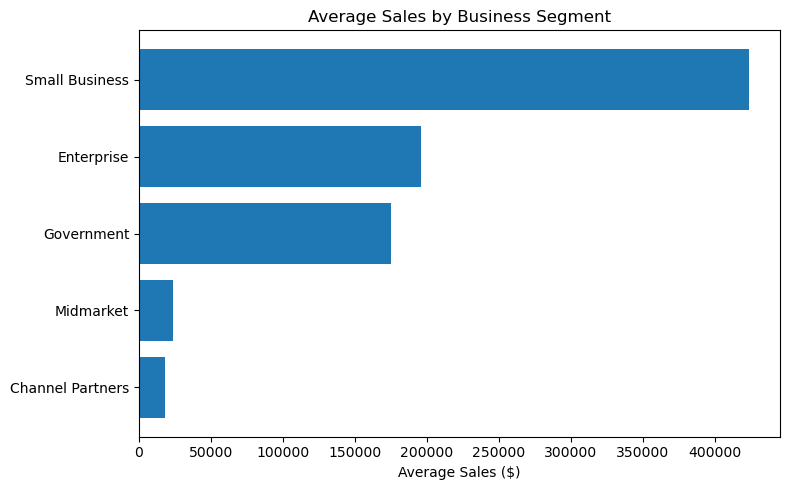

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Load financial data
financials_df = pd.read_csv("Financials.csv")
financials_df.columns = financials_df.columns.str.strip()

# Clean 'Segment' and 'Sales'
financials_df['Segment'] = financials_df['Segment'].str.strip()
financials_df['Sales'] = financials_df['Sales'].replace('[\$,]', '', regex=True)
financials_df['Sales'] = pd.to_numeric(financials_df['Sales'], errors='coerce')

# Aggregate average sales per segment
segment_sales = financials_df.groupby('Segment')['Sales'].mean().reset_index()
segment_sales = segment_sales.sort_values(by='Sales', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(segment_sales['Segment'], segment_sales['Sales'])
plt.xlabel('Average Sales ($)')
plt.title('Average Sales by Business Segment')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


TASK 5-C

This project uses data about directors and companies, and while the information is available to the public, joining it all together can create new risks. When we connect director networks with company performance, it may seem like we are ranking people or saying who is better or worse. But these numbers don’t always show the full picture. A director with fewer links in the network might still be doing very important work. Also, if the data misses out on certain groups, like smaller companies or women directors, it can give an unfair or incomplete result. There’s also the issue of privacy — even if someone’s name is in public records, they may not expect to be analysed this way. That’s why it’s important to be careful with how we explain the results and make sure not to harm anyone’s reputation. The project should aim to understand patterns, not judge individuals. Being fair, clear, and respectful in how we use and share this information is a key ethical responsibility.
